Visualisation of the flights extent and stations positions for the 6 days from the 19th to the 24th of August 2024. 

Organised as follow :

    - Imports
    - Function of maping for stations and flights
    - Plotting

## Imports

In [1]:
from base_Imports_and_Functions import *

## Maping

### Stations

In [11]:
def netatmo_txt(text_file):
    # Read the text file and split lines
    with open(text_file, 'r') as file:
        lines = file.readlines()

    # Extract column names from the first line (assuming it contains column headers)
    column_names = ['id','lon','lat','alt','T','hu','Tbrut','hubrut','t0','t1']
    # Create an empty dictionary to store data for each column
    data = {col: [] for col in column_names}

    # Iterate over the remaining lines to extract data for each column
    for line in lines[1:]:
        values = line.strip().split(' ')
        for col, val in zip(column_names, values):
            if col != 'id' :
                data[col].append(float(val))
            else :
                data[col].append(val)

    # Create a DataFrame from the collected data
    df = pd.DataFrame(data)

    return df

def all_txt(directory):
    
    dfs = []

    text_files = [f for f in os.listdir(directory) if f.endswith('.txt')]
    for text_file in text_files:
        file_path = join(directory,text_file)
        # Read each text file into a DataFrame
        df = netatmo_txt(file_path)  
        dfs.append(df)
        
    concatenated_df = pd.concat(dfs, ignore_index=True)

    return concatenated_df

def convert_to_datetime(datetime_string):
    datetime_obj = datetime.strptime(datetime_string, '%Y%m%d%H%M%S')
    return datetime_obj

def is_a_letter_in(string) :
    res = []
    for i in string :
        res.append(i.isalpha())
    if True in res :
        return True
    else :
        return False

def test_string(s,name_col):
    if '\\' in s:
        return np.nan
    elif s.strip() == '':
        return np.nan  
    elif s.isalpha() :
        return s
    elif name_col == 'date' :
        return convert_to_datetime(s)
    else:
        try:
            if float(s) == 999999 :
                return np.nan
            else : 
                return float(s)
        except ValueError:
            return s

def meteo_france_txt(text_file):
    # Read the text file and split lines
    with open(text_file, 'r') as file:
        lines = file.readlines()

    # Extract column names from the first line (assuming it contains column headers)
    column_names = ['date','type','n°OMM','n°Météo-France','nom_sta','lon','lat',
                    'altitude_baromètre (m)','altitude_station (m)','pression (Pa)',
                   'pr_nmer', 'T-1.5','T_r','hu','precip_1h','dir_vent_moy',
                   'u_moy','u_inst','dir_vent_inst','u_vent_inst_max']
    # Create an empty dictionary to store data for each column
    data = {col: [] for col in column_names}

    # Iterate over the remaining lines to extract data for each column
    for line in lines[1:]:
        values = line.strip().split(';')
        if len(column_names) == len(values) -1 : 
            for col, val in zip(column_names, values):
                data[col].append(test_string(val,col))

    # Create a DataFrame from the collected data
    df = pd.DataFrame(data)

    return df

def all_txt_mf(directory):
    
    dfs = []

    text_files = [f for f in os.listdir(directory) if f.endswith('.txt')]
    for text_file in text_files:
        file_path = join(directory,text_file)
        # Read each text file into a DataFrame
        df = meteo_france_txt(file_path)  
        dfs.append(df)
        
    concatenated_df = pd.concat(dfs, ignore_index=True)

    return concatenated_df

def map_station_fond(img_extent,lon,lat,ax,alpha,color,titre,s, ticks=False):

    min_lon,max_lon,min_lat,max_lat =img_extent[0],img_extent[1],img_extent[2],img_extent[3]
    
    ax.stock_img()
    ax.set_extent([min_lon,max_lon,min_lat,max_lat], crs=ccrs.PlateCarree())
    if ticks:
        ax.set_xticks(np.round(np.arange(min_lon,max_lon, 1)), crs=ccrs.PlateCarree())
        ax.set_yticks(np.round(np.arange(min_lat+1,max_lat, 1)), crs=ccrs.PlateCarree())
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(titre,fontsize=25)
    scatt = ax.scatter(lon,lat, alpha=alpha, s=s, marker='.', color = color)

In [10]:
repos = ['19-08-2023/','20-08-2023/','21-08-2023/','22-08-2023/','23-08-2023/','23-08-2023/']
dfs_daytoday = []
path_netatmo = 'C:/Users/barroisl/Documents/Stage_Leo/Stations/Observations_NETATMO/TEMP_HUM_RELATIVE/'

for i in tqdm(repos) :
    dfs_daytoday.append(all_txt(join(path_netatmo,i)))

repos = ['19-08-2023/','20-08-2023/','21-08-2023/','22-08-2023/','23-08-2023/','23-08-2023/']
dfs_daytoday_mf = []
directory_mf = 'C:/Users/barroisl/Documents/Stage_Leo/Stations/Observations_Meteo-France_et_partenaires/'

for i in tqdm(repos) :
    dfs_daytoday_mf.append(all_txt_mf(join(directory_mf,i)))

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:45<00:00,  7.61s/it]


### Flights

In [2]:
@njit
def filter_list_2(lst1, lst2, threshold_low1=None, threshold_high1=None, threshold_low2=None, threshold_high2=None):
    filtered_list1 = []
    filtered_list2 = []
    for item1,item2 in zip(lst1,lst2):
        if threshold_low1 is not None and item1 < threshold_low1:
            continue
        if threshold_high1 is not None and item1 > threshold_high1:
            continue
        if threshold_low2 is not None and item2 < threshold_low2:
            continue
        if threshold_high2 is not None and item2 > threshold_high2:
            continue
        filtered_list1.append(item1)
        filtered_list2.append(item2)
    return filtered_list1,filtered_list2

def map_all_flights_fond_para_plan(img_extent,directory,ax,type_vol,color,titre,ind1,ind2, ticks=True,cmap='None',vmin=-5,vmax=5):

    min_lon,max_lon,min_lat,max_lat =img_extent[0],img_extent[1],img_extent[2],img_extent[3]
    ax.stock_img()
    ax.set_extent([min_lon,max_lon,min_lat,max_lat], crs=ccrs.PlateCarree())
    if ind1 % 3 == 0:
        ax.set_yticks(np.round(np.arange(min_lat+1,max_lat, 1)), crs=ccrs.PlateCarree())
        ax.set_ylabel("°N",fontsize = 25)

    if ind2 // 3 == 1:
        ax.set_xticks(np.round(np.arange(min_lon,max_lon, 1)),crs=ccrs.PlateCarree())
        ax.set_xlabel("°E",fontsize = 25)

    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(titre,fontsize=25)
    if type_vol == 'para' :
        path = join(directory,'Parapente/')
    elif type_vol == 'plan' :
        path = join(directory,'Planeur/')
    else :
        path = ''
    liste_f = liste_files(join(directory,path))
    for i,file in tqdm(enumerate(liste_f)):
        print(i,end=' ')
        lon,lat,alti,time = read_igc(join(directory,join(path,file)))
        lon,lat = filter_list_2(lon, lat, min_lon-10, max_lon+10,min_lat-10, max_lat+10)
        if cmap=='None':
            ax.plot(lon,lat,color,alpha = 0.3, linewidth = 0.5)

## Plotting

NameError: name 'dfs_daytoday' is not defined

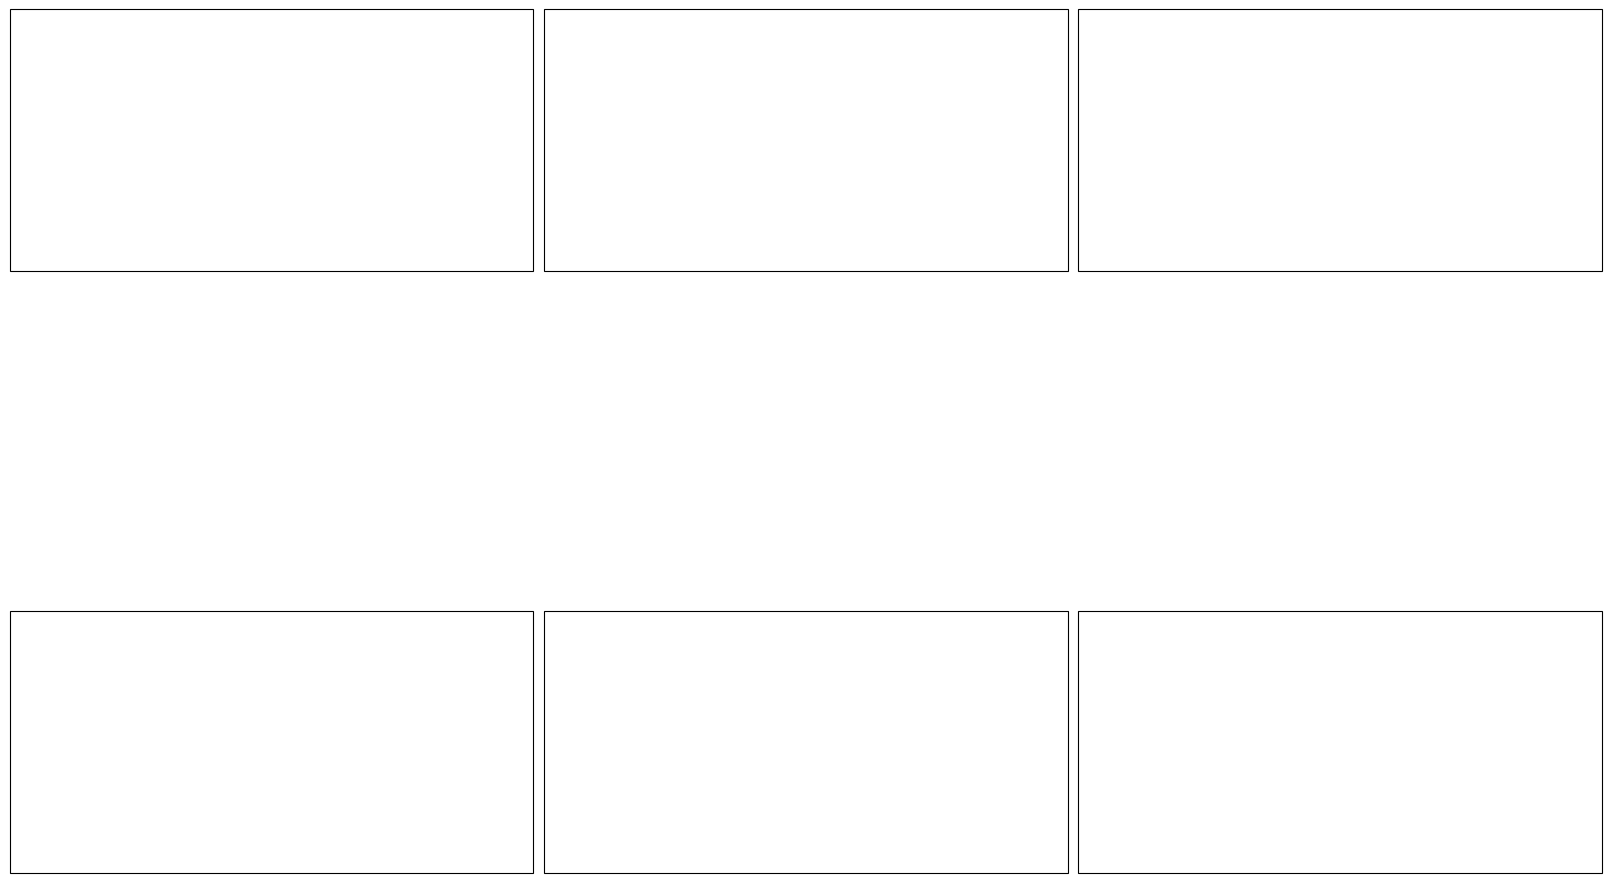

In [4]:
directory_sat = 'C:/Users/barroisl/Documents/Stage_Leo/Satellites/Images_MODIS_VIIRS/'
fnames = ['Alp_2023-08-19_13H01.jpg','Alp_2023-08-20_12H28.jpg','Alp_2023-08-21_12H46.jpg',
          'Alp_2023-08-22_12H40.jpg','Alp_2023-08-23_12H21.jpg','Alp_2023-08-24_13H13.jpg']
days = ['IGC_19-08-2023/','IGC_20-08-2023/','IGC_21-08-2023/','IGC_22-08-2023/','IGC_23-08-2023/','IGC_24-08-2023/']
titres = ["19-08-2023-13-01","20-08-2023-12-28","21-08-2023-12-46","22-08-2023-12-40","23-08-2023-12-21","24-08-2023-13-13"]
directory = 'C:/Users/barroisl/Documents/Stage_Leo/Vols/'

img_extent = (4.7942, 8.1545, 43.3545, 46.6707)

fig,axs = plt.subplots(nrows=2,ncols=3,figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()}, layout = 'constrained')

for i in range(6):
    ax = axs[i//3,i%3]
    img = plt.imread(directory_sat+fnames[i])
    lon,lat = dfs_daytoday[i]['lon'],dfs_daytoday[i]['lat']
    lon_mf,lat_mf = dfs_daytoday_mf[i]['lon'],dfs_daytoday_mf[i]['lat']
    map_station_fond(img_extent,lon_mf,lat_mf,ax,0.1,'firebrick',titres[i],30)
    map_station_fond(img_extent,lon,lat,ax,0.1, 'mediumpurple',titres[i],1)
    map_all_flights_fond_para_plan(img_extent,join(directory,days[i]),ax,'plan','y',titres[i],i,i)
    map_all_flights_fond_para_plan(img_extent,join(directory,days[i]),ax,'para','darkorange',titres[i],i,i)
    ax.imshow(img, origin='upper', extent=img_extent, alpha = 0.8,transform=ccrs.PlateCarree())
    if i == 5 :
        plt.plot([0,1],[0,1],'y',linewidth = 2,label='Gliding')
        plt.plot([0,1],[0,1],'darkorange',linewidth = 2,label='Paragliding')
        plt.scatter(0,0,s=40, color ='firebrick',marker = '.',label='RADOME')
        plt.scatter(0,0,s=26, color ='mediumpurple',marker = '.',label='NETATMO')
    ax.text(0, 1.05, string.ascii_lowercase[i], transform=ax.transAxes, 
                    size=20, weight='bold')
    lats_ville = [44.8997800,44.1875800,45.1666700,46.2043907,43.7101728,45.0704900,46.5160000,45.75,44.933331,44.15,44.75,45.30,43.05]
    lons_ville = [6.6420100,5.9462300,5.7166700,6.1431577,7.2619532,7.6868200,6.6328200,4.85,4.9,6.65,6.10,6.60,6.5]
    names_ville = ['Briançon','Sisteron','Grenoble','Genève','Nice','Turin','Lausanne','Lyon','Valence','Mercantour',
        'Ecrins','Vannoise','Calanques']
    """
    lons_PR = [6.70,5.2,4.55,5.3,6,5.6]
    lats_PR = [44.70,44.3,44.8,44.8,45.7,45.3]
    names_PR = ['Qu','Ar','Bar','Ve','Bau','Ch']
    """
    ax.scatter(lons_ville[:-3],lats_ville[:-3],marker = '+',color = 'k')
    
    for i, txt in enumerate(names_ville):
        if i <= len(names_ville)-5 :
            ax.annotate(txt, (lons_ville[i], lats_ville[i]),size = 20)
#        else : 
#            ax.annotate(txt, (lons_ville[i], lats_ville[i]),size = 15, weight = 'bold')
            
#    for i,txt in enumerate(names_PR):
#        ax.annotate(txt, (lons_PR[i], lats_PR[i]),size = 15, weight = 'bold')
      
plt.legend()

plt.savefig(savefig_path+'Map_stations_flights.png')
plt.show()